In [1]:
import pandas as pd
# get data into np arrays
df = pd.read_csv("data/training_data.csv")
df = pd.get_dummies(df, columns=['stance'])
df['label'] = df[['stance_unrelated','stance_agree','stance_disagree','stance_discuss']].values.tolist()
df['label'] = df['label'].apply(lambda x: x.index(1))
df = df.sample(frac=1)

In [2]:
# grab np values
headlines = df['head'].values
bodies = df['body'].values
labels = df['label'].values

In [2]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Loading BERT tokenizer...


In [4]:
import torch
# tokenization
input_ids = []
attention_masks = []

for i in range(len(headlines)):
    encoded_dict = tokenizer.encode(
                        text=headlines[i],                      # headline to encode.
                        text_pair=bodies[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,
                        pad_to_max_length=True,   # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.   
    #input_ids.append(encoded_dict['input_ids'])
    input_ids.append(encoded_dict)
    
    # And its attention mask (simply differentiates padding from non-padding).
    #attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
#attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', headlines[0], bodies[0])
print('Token IDs:', input_ids[0])

Original:  Is the iPhone 6 Really Pulling Out Your Hair? Fear not arachnophobes, the story of Bunbury's "spiderman" might not be all it seemed.

Perth scientists have cast doubt over claims that a spider burrowed into a man's body during his first trip to Bali. The story went global on Thursday, generating hundreds of stories online.

Earlier this month, Dylan Thomas headed to the holiday island and sought medical help after experiencing "a really burning sensation like a searing feeling" in his abdomen.

Dylan Thomas says he had a spider crawl underneath his skin.

Thomas said a specialist dermatologist was called in and later used tweezers to remove what was believed to be a "tropical spider".

But it seems we may have all been caught in a web... of misinformation.

Arachnologist Dr Volker Framenau said whatever the creature was, it was "almost impossible" for the culprit to have been a spider.

"If you look at a spider, the fangs, the mouth parts they have, they are not able to burr

In [5]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

44,974 training samples
4,998 validation samples


In [6]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [7]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [9]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [10]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [11]:
import numpy as np

# Function to calculate fnc score and max fnc score
def fnc_score(preds, labels):
    y_pred = np.argmax(preds, axis=1).flatten()
    y_true = labels.flatten()

    # compute max_score = 0.25*unrelated + (agree+disagree+discuss)
    total_count = torch.tensor(len(y_true))
    unrelated_count = torch.sum(y_true == 0)
    related_count = total_count - unrelated_count
    max_score = 0.25 * unrelated_count + related_count

    # compute score
    unrelated_pred = y_pred == 0
    unrelated_true = y_true == 0
    correct_unrelated_count = torch.sum(unrelated_pred & unrelated_true)
    correct_unrelated_count_score = 0.25 * correct_unrelated_count

    is_related_mask = ~unrelated_pred
    is_correct_mask = y_true == y_pred

    combined_mask_correct_related = is_related_mask & is_correct_mask
    correct_related_count = torch.sum(combined_mask_correct_related)
    correct_related_count_score = 1.0 * correct_related_count

    is_related_true_mask = ~unrelated_true
    combined_mask_related = is_related_mask & is_related_true_mask
    combined_mask_incorrect_related = combined_mask_related & ~combined_mask_correct_related
    incorrect_related_count = torch.sum(combined_mask_incorrect_related)
    incorrect_related_count_score = 0.25 * incorrect_related_count

    score = correct_unrelated_count_score + correct_related_count_score + incorrect_related_count_score
    return score, max_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return torch.sum(pred_flat == labels_flat).double() / len(labels_flat)

In [12]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [13]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('Using GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Using GPU: TITAN Xp


In [14]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 1 batches.
        if step % 1 == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        #b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(input_ids=b_input_ids,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_fnc_score = 0
    total_eval_max_fnc_score = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        #b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        label_ids = b_labels.to('cpu')

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        # Calculate FNC score, max FNC score for this batch, and accumulate
        b_fnc_score, b_max_fnc_score = fnc_score(logits, label_ids)
        total_eval_fnc_score += b_fnc_score
        total_eval_max_fnc_score += b_max_fnc_score

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    # Report fnc scores over validation run
    relative_score = total_eval_fnc_score / total_eval_max_fnc_score
    print("  FNC Score: {0:.2f}".format(total_eval_fnc_score))
    print("  Maximum Possible FNC Score: {0:.2f}".format(total_eval_max_fnc_score))
    print("  Relative FNC Score: {0:.2f}".format(total_eval_fnc_score / total_eval_max_fnc_score))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'Valid. FNC Score': total_eval_fnc_score,
            'Valid. Max FNC Score': total_eval_max_fnc_score,
            'Relative FNC Score': relative_score
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 12 ========
Training...
  Batch     0  of  1,406.    Elapsed: 0:00:00.


/opt/conda/conda-bld/pytorch_1587428094786/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch     1  of  1,406.    Elapsed: 0:00:01.
  Batch     2  of  1,406.    Elapsed: 0:00:01.
  Batch     3  of  1,406.    Elapsed: 0:00:01.
  Batch     4  of  1,406.    Elapsed: 0:00:02.
  Batch     5  of  1,406.    Elapsed: 0:00:02.
  Batch     6  of  1,406.    Elapsed: 0:00:02.
  Batch     7  of  1,406.    Elapsed: 0:00:02.
  Batch     8  of  1,406.    Elapsed: 0:00:03.
  Batch     9  of  1,406.    Elapsed: 0:00:03.
  Batch    10  of  1,406.    Elapsed: 0:00:03.
  Batch    11  of  1,406.    Elapsed: 0:00:04.
  Batch    12  of  1,406.    Elapsed: 0:00:04.
  Batch    13  of  1,406.    Elapsed: 0:00:04.
  Batch    14  of  1,406.    Elapsed: 0:00:05.
  Batch    15  of  1,406.    Elapsed: 0:00:05.
  Batch    16  of  1,406.    Elapsed: 0:00:05.
  Batch    17  of  1,406.    Elapsed: 0:00:06.
  Batch    18  of  1,406.    Elapsed: 0:00:06.
  Batch    19  of  1,406.    Elapsed: 0:00:06.
  Batch    20  of  1,406.    Elapsed: 0:00:07.
  Batch    21  of  1,406.    Elapsed: 0:00:07.
  Batch    22

  Batch   176  of  1,406.    Elapsed: 0:00:58.
  Batch   177  of  1,406.    Elapsed: 0:00:58.
  Batch   178  of  1,406.    Elapsed: 0:00:59.
  Batch   179  of  1,406.    Elapsed: 0:00:59.
  Batch   180  of  1,406.    Elapsed: 0:00:59.
  Batch   181  of  1,406.    Elapsed: 0:01:00.
  Batch   182  of  1,406.    Elapsed: 0:01:00.
  Batch   183  of  1,406.    Elapsed: 0:01:00.
  Batch   184  of  1,406.    Elapsed: 0:01:01.
  Batch   185  of  1,406.    Elapsed: 0:01:01.
  Batch   186  of  1,406.    Elapsed: 0:01:01.
  Batch   187  of  1,406.    Elapsed: 0:01:02.
  Batch   188  of  1,406.    Elapsed: 0:01:02.
  Batch   189  of  1,406.    Elapsed: 0:01:02.
  Batch   190  of  1,406.    Elapsed: 0:01:03.
  Batch   191  of  1,406.    Elapsed: 0:01:03.
  Batch   192  of  1,406.    Elapsed: 0:01:03.
  Batch   193  of  1,406.    Elapsed: 0:01:04.
  Batch   194  of  1,406.    Elapsed: 0:01:04.
  Batch   195  of  1,406.    Elapsed: 0:01:04.
  Batch   196  of  1,406.    Elapsed: 0:01:05.
  Batch   197

  Batch   351  of  1,406.    Elapsed: 0:01:56.
  Batch   352  of  1,406.    Elapsed: 0:01:57.
  Batch   353  of  1,406.    Elapsed: 0:01:57.
  Batch   354  of  1,406.    Elapsed: 0:01:57.
  Batch   355  of  1,406.    Elapsed: 0:01:58.
  Batch   356  of  1,406.    Elapsed: 0:01:58.
  Batch   357  of  1,406.    Elapsed: 0:01:58.
  Batch   358  of  1,406.    Elapsed: 0:01:59.
  Batch   359  of  1,406.    Elapsed: 0:01:59.
  Batch   360  of  1,406.    Elapsed: 0:01:59.
  Batch   361  of  1,406.    Elapsed: 0:02:00.
  Batch   362  of  1,406.    Elapsed: 0:02:00.
  Batch   363  of  1,406.    Elapsed: 0:02:00.
  Batch   364  of  1,406.    Elapsed: 0:02:01.
  Batch   365  of  1,406.    Elapsed: 0:02:01.
  Batch   366  of  1,406.    Elapsed: 0:02:01.
  Batch   367  of  1,406.    Elapsed: 0:02:02.
  Batch   368  of  1,406.    Elapsed: 0:02:02.
  Batch   369  of  1,406.    Elapsed: 0:02:02.
  Batch   370  of  1,406.    Elapsed: 0:02:03.
  Batch   371  of  1,406.    Elapsed: 0:02:03.
  Batch   372

  Batch   526  of  1,406.    Elapsed: 0:02:55.
  Batch   527  of  1,406.    Elapsed: 0:02:55.
  Batch   528  of  1,406.    Elapsed: 0:02:55.
  Batch   529  of  1,406.    Elapsed: 0:02:56.
  Batch   530  of  1,406.    Elapsed: 0:02:56.
  Batch   531  of  1,406.    Elapsed: 0:02:56.
  Batch   532  of  1,406.    Elapsed: 0:02:57.
  Batch   533  of  1,406.    Elapsed: 0:02:57.
  Batch   534  of  1,406.    Elapsed: 0:02:57.
  Batch   535  of  1,406.    Elapsed: 0:02:58.
  Batch   536  of  1,406.    Elapsed: 0:02:58.
  Batch   537  of  1,406.    Elapsed: 0:02:58.
  Batch   538  of  1,406.    Elapsed: 0:02:59.
  Batch   539  of  1,406.    Elapsed: 0:02:59.
  Batch   540  of  1,406.    Elapsed: 0:02:59.
  Batch   541  of  1,406.    Elapsed: 0:03:00.
  Batch   542  of  1,406.    Elapsed: 0:03:00.
  Batch   543  of  1,406.    Elapsed: 0:03:00.
  Batch   544  of  1,406.    Elapsed: 0:03:01.
  Batch   545  of  1,406.    Elapsed: 0:03:01.
  Batch   546  of  1,406.    Elapsed: 0:03:01.
  Batch   547

  Batch   701  of  1,406.    Elapsed: 0:03:53.
  Batch   702  of  1,406.    Elapsed: 0:03:54.
  Batch   703  of  1,406.    Elapsed: 0:03:54.
  Batch   704  of  1,406.    Elapsed: 0:03:54.
  Batch   705  of  1,406.    Elapsed: 0:03:55.
  Batch   706  of  1,406.    Elapsed: 0:03:55.
  Batch   707  of  1,406.    Elapsed: 0:03:55.
  Batch   708  of  1,406.    Elapsed: 0:03:56.
  Batch   709  of  1,406.    Elapsed: 0:03:56.
  Batch   710  of  1,406.    Elapsed: 0:03:56.
  Batch   711  of  1,406.    Elapsed: 0:03:57.
  Batch   712  of  1,406.    Elapsed: 0:03:57.
  Batch   713  of  1,406.    Elapsed: 0:03:57.
  Batch   714  of  1,406.    Elapsed: 0:03:58.
  Batch   715  of  1,406.    Elapsed: 0:03:58.
  Batch   716  of  1,406.    Elapsed: 0:03:58.
  Batch   717  of  1,406.    Elapsed: 0:03:59.
  Batch   718  of  1,406.    Elapsed: 0:03:59.
  Batch   719  of  1,406.    Elapsed: 0:03:59.
  Batch   720  of  1,406.    Elapsed: 0:04:00.
  Batch   721  of  1,406.    Elapsed: 0:04:00.
  Batch   722

  Batch   876  of  1,406.    Elapsed: 0:04:52.
  Batch   877  of  1,406.    Elapsed: 0:04:52.
  Batch   878  of  1,406.    Elapsed: 0:04:53.
  Batch   879  of  1,406.    Elapsed: 0:04:53.
  Batch   880  of  1,406.    Elapsed: 0:04:53.
  Batch   881  of  1,406.    Elapsed: 0:04:54.
  Batch   882  of  1,406.    Elapsed: 0:04:54.
  Batch   883  of  1,406.    Elapsed: 0:04:54.
  Batch   884  of  1,406.    Elapsed: 0:04:55.
  Batch   885  of  1,406.    Elapsed: 0:04:55.
  Batch   886  of  1,406.    Elapsed: 0:04:55.
  Batch   887  of  1,406.    Elapsed: 0:04:56.
  Batch   888  of  1,406.    Elapsed: 0:04:56.
  Batch   889  of  1,406.    Elapsed: 0:04:56.
  Batch   890  of  1,406.    Elapsed: 0:04:57.
  Batch   891  of  1,406.    Elapsed: 0:04:57.
  Batch   892  of  1,406.    Elapsed: 0:04:57.
  Batch   893  of  1,406.    Elapsed: 0:04:58.
  Batch   894  of  1,406.    Elapsed: 0:04:58.
  Batch   895  of  1,406.    Elapsed: 0:04:58.
  Batch   896  of  1,406.    Elapsed: 0:04:59.
  Batch   897

  Batch 1,052  of  1,406.    Elapsed: 0:05:51.
  Batch 1,053  of  1,406.    Elapsed: 0:05:51.
  Batch 1,054  of  1,406.    Elapsed: 0:05:52.
  Batch 1,055  of  1,406.    Elapsed: 0:05:52.
  Batch 1,056  of  1,406.    Elapsed: 0:05:52.
  Batch 1,057  of  1,406.    Elapsed: 0:05:53.
  Batch 1,058  of  1,406.    Elapsed: 0:05:53.
  Batch 1,059  of  1,406.    Elapsed: 0:05:53.
  Batch 1,060  of  1,406.    Elapsed: 0:05:54.
  Batch 1,061  of  1,406.    Elapsed: 0:05:54.
  Batch 1,062  of  1,406.    Elapsed: 0:05:54.
  Batch 1,063  of  1,406.    Elapsed: 0:05:55.
  Batch 1,064  of  1,406.    Elapsed: 0:05:55.
  Batch 1,065  of  1,406.    Elapsed: 0:05:55.
  Batch 1,066  of  1,406.    Elapsed: 0:05:56.
  Batch 1,067  of  1,406.    Elapsed: 0:05:56.
  Batch 1,068  of  1,406.    Elapsed: 0:05:56.
  Batch 1,069  of  1,406.    Elapsed: 0:05:57.
  Batch 1,070  of  1,406.    Elapsed: 0:05:57.
  Batch 1,071  of  1,406.    Elapsed: 0:05:57.
  Batch 1,072  of  1,406.    Elapsed: 0:05:58.
  Batch 1,073

  Batch 1,227  of  1,406.    Elapsed: 0:06:50.
  Batch 1,228  of  1,406.    Elapsed: 0:06:50.
  Batch 1,229  of  1,406.    Elapsed: 0:06:50.
  Batch 1,230  of  1,406.    Elapsed: 0:06:51.
  Batch 1,231  of  1,406.    Elapsed: 0:06:51.
  Batch 1,232  of  1,406.    Elapsed: 0:06:51.
  Batch 1,233  of  1,406.    Elapsed: 0:06:52.
  Batch 1,234  of  1,406.    Elapsed: 0:06:52.
  Batch 1,235  of  1,406.    Elapsed: 0:06:52.
  Batch 1,236  of  1,406.    Elapsed: 0:06:53.
  Batch 1,237  of  1,406.    Elapsed: 0:06:53.
  Batch 1,238  of  1,406.    Elapsed: 0:06:53.
  Batch 1,239  of  1,406.    Elapsed: 0:06:54.
  Batch 1,240  of  1,406.    Elapsed: 0:06:54.
  Batch 1,241  of  1,406.    Elapsed: 0:06:55.
  Batch 1,242  of  1,406.    Elapsed: 0:06:55.
  Batch 1,243  of  1,406.    Elapsed: 0:06:55.
  Batch 1,244  of  1,406.    Elapsed: 0:06:56.
  Batch 1,245  of  1,406.    Elapsed: 0:06:56.
  Batch 1,246  of  1,406.    Elapsed: 0:06:56.
  Batch 1,247  of  1,406.    Elapsed: 0:06:57.
  Batch 1,248

  Batch 1,402  of  1,406.    Elapsed: 0:07:49.
  Batch 1,403  of  1,406.    Elapsed: 0:07:49.
  Batch 1,404  of  1,406.    Elapsed: 0:07:49.
  Batch 1,405  of  1,406.    Elapsed: 0:07:50.

  Average training loss: 0.25
  Training epoch took: 0:07:50

Running Validation...
  Accuracy: 0.96
  FNC Score: 2107.75
  Maximum Possible FNC Score: 2250.00
  Relative FNC Score: 0.94
  Validation Loss: 0.11
  Validation took: 0:00:16

======== Epoch 2 / 12 ========
Training...
  Batch     0  of  1,406.    Elapsed: 0:00:00.
  Batch     1  of  1,406.    Elapsed: 0:00:00.
  Batch     2  of  1,406.    Elapsed: 0:00:01.
  Batch     3  of  1,406.    Elapsed: 0:00:01.
  Batch     4  of  1,406.    Elapsed: 0:00:01.
  Batch     5  of  1,406.    Elapsed: 0:00:02.
  Batch     6  of  1,406.    Elapsed: 0:00:02.
  Batch     7  of  1,406.    Elapsed: 0:00:02.
  Batch     8  of  1,406.    Elapsed: 0:00:03.
  Batch     9  of  1,406.    Elapsed: 0:00:03.
  Batch    10  of  1,406.    Elapsed: 0:00:03.
  Batch    1

  Batch   165  of  1,406.    Elapsed: 0:00:55.
  Batch   401  of  1,406.    Elapsed: 0:02:14.
  Batch   402  of  1,406.    Elapsed: 0:02:14.
  Batch   403  of  1,406.    Elapsed: 0:02:14.
  Batch   404  of  1,406.    Elapsed: 0:02:15.
  Batch   405  of  1,406.    Elapsed: 0:02:15.
  Batch   406  of  1,406.    Elapsed: 0:02:16.
  Batch   407  of  1,406.    Elapsed: 0:02:16.
  Batch   408  of  1,406.    Elapsed: 0:02:16.
  Batch   409  of  1,406.    Elapsed: 0:02:17.
  Batch   410  of  1,406.    Elapsed: 0:02:17.
  Batch   411  of  1,406.    Elapsed: 0:02:17.
  Batch   412  of  1,406.    Elapsed: 0:02:18.
  Batch   413  of  1,406.    Elapsed: 0:02:18.
  Batch   414  of  1,406.    Elapsed: 0:02:18.
  Batch   415  of  1,406.    Elapsed: 0:02:19.
  Batch   416  of  1,406.    Elapsed: 0:02:19.
  Batch   417  of  1,406.    Elapsed: 0:02:19.
  Batch   418  of  1,406.    Elapsed: 0:02:20.
  Batch   419  of  1,406.    Elapsed: 0:02:20.
  Batch   420  of  1,406.    Elapsed: 0:02:20.
  Batch   421

  Batch   575  of  1,406.    Elapsed: 0:03:12.
  Batch   576  of  1,406.    Elapsed: 0:03:12.
  Batch   577  of  1,406.    Elapsed: 0:03:13.
  Batch   578  of  1,406.    Elapsed: 0:03:13.
  Batch   579  of  1,406.    Elapsed: 0:03:13.
  Batch   580  of  1,406.    Elapsed: 0:03:14.
  Batch   581  of  1,406.    Elapsed: 0:03:14.
  Batch   582  of  1,406.    Elapsed: 0:03:14.
  Batch   583  of  1,406.    Elapsed: 0:03:15.
  Batch   584  of  1,406.    Elapsed: 0:03:15.
  Batch   585  of  1,406.    Elapsed: 0:03:15.
  Batch   586  of  1,406.    Elapsed: 0:03:16.
  Batch   587  of  1,406.    Elapsed: 0:03:16.
  Batch   588  of  1,406.    Elapsed: 0:03:16.
  Batch   589  of  1,406.    Elapsed: 0:03:17.
  Batch   590  of  1,406.    Elapsed: 0:03:17.
  Batch   591  of  1,406.    Elapsed: 0:03:17.
  Batch   592  of  1,406.    Elapsed: 0:03:18.
  Batch   593  of  1,406.    Elapsed: 0:03:18.
  Batch   594  of  1,406.    Elapsed: 0:03:18.
  Batch   595  of  1,406.    Elapsed: 0:03:19.
  Batch   596

  Batch   750  of  1,406.    Elapsed: 0:04:10.
  Batch   751  of  1,406.    Elapsed: 0:04:11.
  Batch   752  of  1,406.    Elapsed: 0:04:11.
  Batch   753  of  1,406.    Elapsed: 0:04:11.
  Batch   754  of  1,406.    Elapsed: 0:04:12.
  Batch   755  of  1,406.    Elapsed: 0:04:12.
  Batch   756  of  1,406.    Elapsed: 0:04:12.
  Batch   757  of  1,406.    Elapsed: 0:04:13.
  Batch   758  of  1,406.    Elapsed: 0:04:13.
  Batch   759  of  1,406.    Elapsed: 0:04:13.
  Batch   760  of  1,406.    Elapsed: 0:04:14.
  Batch   761  of  1,406.    Elapsed: 0:04:14.
  Batch   762  of  1,406.    Elapsed: 0:04:14.
  Batch   763  of  1,406.    Elapsed: 0:04:15.
  Batch   764  of  1,406.    Elapsed: 0:04:15.
  Batch   765  of  1,406.    Elapsed: 0:04:15.
  Batch   766  of  1,406.    Elapsed: 0:04:16.
  Batch   767  of  1,406.    Elapsed: 0:04:16.
  Batch   768  of  1,406.    Elapsed: 0:04:16.
  Batch   769  of  1,406.    Elapsed: 0:04:17.
  Batch   770  of  1,406.    Elapsed: 0:04:17.
  Batch   771

  Batch   925  of  1,406.    Elapsed: 0:05:09.
  Batch   926  of  1,406.    Elapsed: 0:05:09.
  Batch   927  of  1,406.    Elapsed: 0:05:09.
  Batch   928  of  1,406.    Elapsed: 0:05:10.
  Batch   929  of  1,406.    Elapsed: 0:05:10.
  Batch   930  of  1,406.    Elapsed: 0:05:10.
  Batch   931  of  1,406.    Elapsed: 0:05:11.
  Batch   932  of  1,406.    Elapsed: 0:05:11.
  Batch   933  of  1,406.    Elapsed: 0:05:11.
  Batch   934  of  1,406.    Elapsed: 0:05:12.
  Batch   935  of  1,406.    Elapsed: 0:05:12.
  Batch   936  of  1,406.    Elapsed: 0:05:12.
  Batch   937  of  1,406.    Elapsed: 0:05:13.
  Batch   938  of  1,406.    Elapsed: 0:05:13.
  Batch   939  of  1,406.    Elapsed: 0:05:13.
  Batch   940  of  1,406.    Elapsed: 0:05:14.
  Batch   941  of  1,406.    Elapsed: 0:05:14.
  Batch   942  of  1,406.    Elapsed: 0:05:14.
  Batch   943  of  1,406.    Elapsed: 0:05:15.
  Batch   944  of  1,406.    Elapsed: 0:05:15.
  Batch   945  of  1,406.    Elapsed: 0:05:15.
  Batch   946

  Batch 1,100  of  1,406.    Elapsed: 0:06:07.
  Batch 1,101  of  1,406.    Elapsed: 0:06:08.
  Batch 1,102  of  1,406.    Elapsed: 0:06:08.
  Batch 1,103  of  1,406.    Elapsed: 0:06:08.
  Batch 1,104  of  1,406.    Elapsed: 0:06:09.
  Batch 1,105  of  1,406.    Elapsed: 0:06:09.
  Batch 1,106  of  1,406.    Elapsed: 0:06:09.
  Batch 1,107  of  1,406.    Elapsed: 0:06:10.
  Batch 1,108  of  1,406.    Elapsed: 0:06:10.
  Batch 1,109  of  1,406.    Elapsed: 0:06:10.
  Batch 1,110  of  1,406.    Elapsed: 0:06:11.
  Batch 1,111  of  1,406.    Elapsed: 0:06:11.
  Batch 1,112  of  1,406.    Elapsed: 0:06:11.
  Batch 1,113  of  1,406.    Elapsed: 0:06:12.
  Batch 1,114  of  1,406.    Elapsed: 0:06:12.
  Batch 1,115  of  1,406.    Elapsed: 0:06:12.
  Batch 1,116  of  1,406.    Elapsed: 0:06:13.
  Batch 1,117  of  1,406.    Elapsed: 0:06:13.
  Batch 1,118  of  1,406.    Elapsed: 0:06:13.
  Batch 1,119  of  1,406.    Elapsed: 0:06:14.
  Batch 1,120  of  1,406.    Elapsed: 0:06:14.
  Batch 1,121

  Batch 1,275  of  1,406.    Elapsed: 0:07:06.
  Batch 1,276  of  1,406.    Elapsed: 0:07:06.
  Batch 1,277  of  1,406.    Elapsed: 0:07:06.
  Batch 1,278  of  1,406.    Elapsed: 0:07:07.
  Batch 1,279  of  1,406.    Elapsed: 0:07:07.
  Batch 1,280  of  1,406.    Elapsed: 0:07:07.
  Batch 1,281  of  1,406.    Elapsed: 0:07:08.
  Batch 1,282  of  1,406.    Elapsed: 0:07:08.
  Batch 1,283  of  1,406.    Elapsed: 0:07:08.
  Batch 1,284  of  1,406.    Elapsed: 0:07:09.
  Batch 1,285  of  1,406.    Elapsed: 0:07:09.
  Batch 1,286  of  1,406.    Elapsed: 0:07:09.
  Batch 1,287  of  1,406.    Elapsed: 0:07:10.
  Batch 1,288  of  1,406.    Elapsed: 0:07:10.
  Batch 1,289  of  1,406.    Elapsed: 0:07:10.
  Batch 1,290  of  1,406.    Elapsed: 0:07:11.
  Batch 1,291  of  1,406.    Elapsed: 0:07:11.
  Batch 1,292  of  1,406.    Elapsed: 0:07:11.
  Batch 1,293  of  1,406.    Elapsed: 0:07:12.
  Batch 1,294  of  1,406.    Elapsed: 0:07:12.
  Batch 1,295  of  1,406.    Elapsed: 0:07:12.
  Batch 1,296

  Batch    38  of  1,406.    Elapsed: 0:00:13.
  Batch    39  of  1,406.    Elapsed: 0:00:13.
  Batch    40  of  1,406.    Elapsed: 0:00:13.
  Batch    41  of  1,406.    Elapsed: 0:00:14.
  Batch    42  of  1,406.    Elapsed: 0:00:14.
  Batch    43  of  1,406.    Elapsed: 0:00:14.
  Batch    44  of  1,406.    Elapsed: 0:00:15.
  Batch    45  of  1,406.    Elapsed: 0:00:15.
  Batch    46  of  1,406.    Elapsed: 0:00:15.
  Batch    47  of  1,406.    Elapsed: 0:00:16.
  Batch    48  of  1,406.    Elapsed: 0:00:16.
  Batch    49  of  1,406.    Elapsed: 0:00:16.
  Batch    50  of  1,406.    Elapsed: 0:00:17.
  Batch    51  of  1,406.    Elapsed: 0:00:17.
  Batch    52  of  1,406.    Elapsed: 0:00:17.
  Batch    53  of  1,406.    Elapsed: 0:00:18.
  Batch    54  of  1,406.    Elapsed: 0:00:18.
  Batch    55  of  1,406.    Elapsed: 0:00:18.
  Batch    56  of  1,406.    Elapsed: 0:00:19.
  Batch    57  of  1,406.    Elapsed: 0:00:19.
  Batch    58  of  1,406.    Elapsed: 0:00:19.
  Batch    59

  Batch   213  of  1,406.    Elapsed: 0:01:11.
  Batch   214  of  1,406.    Elapsed: 0:01:11.
  Batch   215  of  1,406.    Elapsed: 0:01:12.
  Batch   216  of  1,406.    Elapsed: 0:01:12.
  Batch   217  of  1,406.    Elapsed: 0:01:12.
  Batch   218  of  1,406.    Elapsed: 0:01:13.
  Batch   219  of  1,406.    Elapsed: 0:01:13.
  Batch   220  of  1,406.    Elapsed: 0:01:13.
  Batch   221  of  1,406.    Elapsed: 0:01:14.
  Batch   222  of  1,406.    Elapsed: 0:01:14.
  Batch   223  of  1,406.    Elapsed: 0:01:14.
  Batch   224  of  1,406.    Elapsed: 0:01:15.
  Batch   225  of  1,406.    Elapsed: 0:01:15.
  Batch   226  of  1,406.    Elapsed: 0:01:15.
  Batch   227  of  1,406.    Elapsed: 0:01:16.
  Batch   228  of  1,406.    Elapsed: 0:01:16.
  Batch   229  of  1,406.    Elapsed: 0:01:16.
  Batch   230  of  1,406.    Elapsed: 0:01:17.
  Batch   231  of  1,406.    Elapsed: 0:01:17.
  Batch   232  of  1,406.    Elapsed: 0:01:17.
  Batch   233  of  1,406.    Elapsed: 0:01:18.
  Batch   234

  Batch   388  of  1,406.    Elapsed: 0:02:09.
  Batch   389  of  1,406.    Elapsed: 0:02:10.
  Batch   390  of  1,406.    Elapsed: 0:02:10.
  Batch   391  of  1,406.    Elapsed: 0:02:10.
  Batch   392  of  1,406.    Elapsed: 0:02:11.
  Batch   393  of  1,406.    Elapsed: 0:02:11.
  Batch   394  of  1,406.    Elapsed: 0:02:11.
  Batch   395  of  1,406.    Elapsed: 0:02:12.
  Batch   396  of  1,406.    Elapsed: 0:02:12.
  Batch   397  of  1,406.    Elapsed: 0:02:12.
  Batch   398  of  1,406.    Elapsed: 0:02:13.
  Batch   399  of  1,406.    Elapsed: 0:02:13.
  Batch   400  of  1,406.    Elapsed: 0:02:13.
  Batch   401  of  1,406.    Elapsed: 0:02:14.
  Batch   402  of  1,406.    Elapsed: 0:02:14.
  Batch   403  of  1,406.    Elapsed: 0:02:14.
  Batch   404  of  1,406.    Elapsed: 0:02:15.
  Batch   405  of  1,406.    Elapsed: 0:02:15.
  Batch   406  of  1,406.    Elapsed: 0:02:15.
  Batch   407  of  1,406.    Elapsed: 0:02:16.
  Batch   408  of  1,406.    Elapsed: 0:02:16.
  Batch   409

  Batch   563  of  1,406.    Elapsed: 0:03:08.
  Batch   564  of  1,406.    Elapsed: 0:03:08.
  Batch   565  of  1,406.    Elapsed: 0:03:08.
  Batch   566  of  1,406.    Elapsed: 0:03:09.
  Batch   567  of  1,406.    Elapsed: 0:03:09.
  Batch   568  of  1,406.    Elapsed: 0:03:09.
  Batch   569  of  1,406.    Elapsed: 0:03:10.
  Batch   570  of  1,406.    Elapsed: 0:03:10.
  Batch   571  of  1,406.    Elapsed: 0:03:10.
  Batch   572  of  1,406.    Elapsed: 0:03:11.
  Batch   573  of  1,406.    Elapsed: 0:03:11.
  Batch   574  of  1,406.    Elapsed: 0:03:11.
  Batch   575  of  1,406.    Elapsed: 0:03:12.
  Batch   576  of  1,406.    Elapsed: 0:03:12.
  Batch   577  of  1,406.    Elapsed: 0:03:12.
  Batch   578  of  1,406.    Elapsed: 0:03:13.
  Batch   579  of  1,406.    Elapsed: 0:03:13.
  Batch   580  of  1,406.    Elapsed: 0:03:13.
  Batch   581  of  1,406.    Elapsed: 0:03:14.
  Batch   582  of  1,406.    Elapsed: 0:03:14.
  Batch   583  of  1,406.    Elapsed: 0:03:14.
  Batch   584

  Batch   738  of  1,406.    Elapsed: 0:04:06.
  Batch   739  of  1,406.    Elapsed: 0:04:06.
  Batch   740  of  1,406.    Elapsed: 0:04:06.
  Batch   741  of  1,406.    Elapsed: 0:04:07.
  Batch   742  of  1,406.    Elapsed: 0:04:07.
  Batch   743  of  1,406.    Elapsed: 0:04:07.
  Batch   744  of  1,406.    Elapsed: 0:04:08.
  Batch   745  of  1,406.    Elapsed: 0:04:08.
  Batch   746  of  1,406.    Elapsed: 0:04:08.
  Batch   747  of  1,406.    Elapsed: 0:04:09.
  Batch   748  of  1,406.    Elapsed: 0:04:09.
  Batch   749  of  1,406.    Elapsed: 0:04:09.
  Batch   750  of  1,406.    Elapsed: 0:04:10.
  Batch   751  of  1,406.    Elapsed: 0:04:10.
  Batch   752  of  1,406.    Elapsed: 0:04:10.
  Batch   753  of  1,406.    Elapsed: 0:04:11.
  Batch   754  of  1,406.    Elapsed: 0:04:11.
  Batch   755  of  1,406.    Elapsed: 0:04:11.
  Batch   756  of  1,406.    Elapsed: 0:04:12.
  Batch   757  of  1,406.    Elapsed: 0:04:12.
  Batch   758  of  1,406.    Elapsed: 0:04:12.
  Batch   759

  Batch   913  of  1,406.    Elapsed: 0:05:04.
  Batch   914  of  1,406.    Elapsed: 0:05:04.
  Batch   915  of  1,406.    Elapsed: 0:05:05.
  Batch   916  of  1,406.    Elapsed: 0:05:05.
  Batch   917  of  1,406.    Elapsed: 0:05:05.
  Batch   918  of  1,406.    Elapsed: 0:05:06.
  Batch   919  of  1,406.    Elapsed: 0:05:06.
  Batch   920  of  1,406.    Elapsed: 0:05:06.
  Batch   921  of  1,406.    Elapsed: 0:05:07.
  Batch   922  of  1,406.    Elapsed: 0:05:07.
  Batch   923  of  1,406.    Elapsed: 0:05:07.
  Batch   924  of  1,406.    Elapsed: 0:05:08.
  Batch   925  of  1,406.    Elapsed: 0:05:08.
  Batch   926  of  1,406.    Elapsed: 0:05:08.
  Batch   927  of  1,406.    Elapsed: 0:05:09.
  Batch   928  of  1,406.    Elapsed: 0:05:09.
  Batch   929  of  1,406.    Elapsed: 0:05:09.
  Batch   930  of  1,406.    Elapsed: 0:05:10.
  Batch   931  of  1,406.    Elapsed: 0:05:10.
  Batch   932  of  1,406.    Elapsed: 0:05:10.
  Batch   933  of  1,406.    Elapsed: 0:05:11.
  Batch   934

  Batch 1,088  of  1,406.    Elapsed: 0:06:02.
  Batch 1,089  of  1,406.    Elapsed: 0:06:03.
  Batch 1,090  of  1,406.    Elapsed: 0:06:03.
  Batch 1,091  of  1,406.    Elapsed: 0:06:03.
  Batch 1,092  of  1,406.    Elapsed: 0:06:04.
  Batch 1,093  of  1,406.    Elapsed: 0:06:04.
  Batch 1,094  of  1,406.    Elapsed: 0:06:04.
  Batch 1,095  of  1,406.    Elapsed: 0:06:05.
  Batch 1,096  of  1,406.    Elapsed: 0:06:05.
  Batch 1,097  of  1,406.    Elapsed: 0:06:05.
  Batch 1,098  of  1,406.    Elapsed: 0:06:06.
  Batch 1,099  of  1,406.    Elapsed: 0:06:06.
  Batch 1,100  of  1,406.    Elapsed: 0:06:06.
  Batch 1,101  of  1,406.    Elapsed: 0:06:07.
  Batch 1,102  of  1,406.    Elapsed: 0:06:07.
  Batch 1,103  of  1,406.    Elapsed: 0:06:07.
  Batch 1,104  of  1,406.    Elapsed: 0:06:08.
  Batch 1,105  of  1,406.    Elapsed: 0:06:08.
  Batch 1,106  of  1,406.    Elapsed: 0:06:08.
  Batch 1,107  of  1,406.    Elapsed: 0:06:09.
  Batch 1,108  of  1,406.    Elapsed: 0:06:09.
  Batch 1,109

  Batch 1,263  of  1,406.    Elapsed: 0:07:01.
  Batch 1,264  of  1,406.    Elapsed: 0:07:01.
  Batch 1,265  of  1,406.    Elapsed: 0:07:01.
  Batch 1,266  of  1,406.    Elapsed: 0:07:02.
  Batch 1,267  of  1,406.    Elapsed: 0:07:02.
  Batch 1,268  of  1,406.    Elapsed: 0:07:02.
  Batch 1,269  of  1,406.    Elapsed: 0:07:03.
  Batch 1,270  of  1,406.    Elapsed: 0:07:03.
  Batch 1,271  of  1,406.    Elapsed: 0:07:03.
  Batch 1,272  of  1,406.    Elapsed: 0:07:04.
  Batch 1,273  of  1,406.    Elapsed: 0:07:04.
  Batch 1,274  of  1,406.    Elapsed: 0:07:04.
  Batch 1,275  of  1,406.    Elapsed: 0:07:05.
  Batch 1,276  of  1,406.    Elapsed: 0:07:05.
  Batch 1,277  of  1,406.    Elapsed: 0:07:05.
  Batch 1,278  of  1,406.    Elapsed: 0:07:06.
  Batch 1,279  of  1,406.    Elapsed: 0:07:06.
  Batch 1,280  of  1,406.    Elapsed: 0:07:06.
  Batch 1,281  of  1,406.    Elapsed: 0:07:07.
  Batch 1,282  of  1,406.    Elapsed: 0:07:07.
  Batch 1,283  of  1,406.    Elapsed: 0:07:07.
  Batch 1,284

  Batch    26  of  1,406.    Elapsed: 0:00:09.
  Batch    27  of  1,406.    Elapsed: 0:00:09.
  Batch    28  of  1,406.    Elapsed: 0:00:09.
  Batch    29  of  1,406.    Elapsed: 0:00:10.
  Batch    30  of  1,406.    Elapsed: 0:00:10.
  Batch    31  of  1,406.    Elapsed: 0:00:10.
  Batch    32  of  1,406.    Elapsed: 0:00:11.
  Batch    33  of  1,406.    Elapsed: 0:00:11.
  Batch    34  of  1,406.    Elapsed: 0:00:11.
  Batch    35  of  1,406.    Elapsed: 0:00:12.
  Batch    36  of  1,406.    Elapsed: 0:00:12.
  Batch    37  of  1,406.    Elapsed: 0:00:12.
  Batch    38  of  1,406.    Elapsed: 0:00:13.
  Batch    39  of  1,406.    Elapsed: 0:00:13.
  Batch    40  of  1,406.    Elapsed: 0:00:13.
  Batch    41  of  1,406.    Elapsed: 0:00:14.
  Batch    42  of  1,406.    Elapsed: 0:00:14.
  Batch    43  of  1,406.    Elapsed: 0:00:14.
  Batch    44  of  1,406.    Elapsed: 0:00:15.
  Batch    45  of  1,406.    Elapsed: 0:00:15.
  Batch    46  of  1,406.    Elapsed: 0:00:15.
  Batch    47

  Batch   201  of  1,406.    Elapsed: 0:01:07.
  Batch   202  of  1,406.    Elapsed: 0:01:07.
  Batch   203  of  1,406.    Elapsed: 0:01:08.
  Batch   204  of  1,406.    Elapsed: 0:01:08.
  Batch   205  of  1,406.    Elapsed: 0:01:08.
  Batch   206  of  1,406.    Elapsed: 0:01:09.
  Batch   207  of  1,406.    Elapsed: 0:01:09.
  Batch   208  of  1,406.    Elapsed: 0:01:09.
  Batch   209  of  1,406.    Elapsed: 0:01:10.
  Batch   210  of  1,406.    Elapsed: 0:01:10.
  Batch   211  of  1,406.    Elapsed: 0:01:10.
  Batch   212  of  1,406.    Elapsed: 0:01:11.
  Batch   213  of  1,406.    Elapsed: 0:01:11.
  Batch   214  of  1,406.    Elapsed: 0:01:11.
  Batch   215  of  1,406.    Elapsed: 0:01:12.
  Batch   216  of  1,406.    Elapsed: 0:01:12.
  Batch   217  of  1,406.    Elapsed: 0:01:12.
  Batch   218  of  1,406.    Elapsed: 0:01:12.
  Batch   219  of  1,406.    Elapsed: 0:01:13.
  Batch   220  of  1,406.    Elapsed: 0:01:13.
  Batch   221  of  1,406.    Elapsed: 0:01:13.
  Batch   222

  Batch   376  of  1,406.    Elapsed: 0:02:05.
  Batch   377  of  1,406.    Elapsed: 0:02:05.
  Batch   378  of  1,406.    Elapsed: 0:02:06.
  Batch   379  of  1,406.    Elapsed: 0:02:06.
  Batch   380  of  1,406.    Elapsed: 0:02:06.
  Batch   381  of  1,406.    Elapsed: 0:02:07.
  Batch   382  of  1,406.    Elapsed: 0:02:07.
  Batch   383  of  1,406.    Elapsed: 0:02:07.
  Batch   384  of  1,406.    Elapsed: 0:02:08.
  Batch   385  of  1,406.    Elapsed: 0:02:08.
  Batch   386  of  1,406.    Elapsed: 0:02:08.
  Batch   387  of  1,406.    Elapsed: 0:02:09.
  Batch   388  of  1,406.    Elapsed: 0:02:09.
  Batch   389  of  1,406.    Elapsed: 0:02:09.
  Batch   390  of  1,406.    Elapsed: 0:02:10.
  Batch   391  of  1,406.    Elapsed: 0:02:10.
  Batch   392  of  1,406.    Elapsed: 0:02:10.
  Batch   393  of  1,406.    Elapsed: 0:02:11.
  Batch   394  of  1,406.    Elapsed: 0:02:11.
  Batch   395  of  1,406.    Elapsed: 0:02:11.
  Batch   396  of  1,406.    Elapsed: 0:02:12.
  Batch   397

  Batch   551  of  1,406.    Elapsed: 0:03:03.
  Batch   552  of  1,406.    Elapsed: 0:03:04.
  Batch   553  of  1,406.    Elapsed: 0:03:04.
  Batch   554  of  1,406.    Elapsed: 0:03:04.
  Batch   555  of  1,406.    Elapsed: 0:03:05.
  Batch   556  of  1,406.    Elapsed: 0:03:05.
  Batch   557  of  1,406.    Elapsed: 0:03:05.
  Batch   558  of  1,406.    Elapsed: 0:03:06.
  Batch   559  of  1,406.    Elapsed: 0:03:06.
  Batch   560  of  1,406.    Elapsed: 0:03:06.
  Batch   561  of  1,406.    Elapsed: 0:03:06.
  Batch   562  of  1,406.    Elapsed: 0:03:07.
  Batch   563  of  1,406.    Elapsed: 0:03:07.
  Batch   564  of  1,406.    Elapsed: 0:03:07.
  Batch   565  of  1,406.    Elapsed: 0:03:08.
  Batch   566  of  1,406.    Elapsed: 0:03:08.
  Batch   567  of  1,406.    Elapsed: 0:03:08.
  Batch   568  of  1,406.    Elapsed: 0:03:09.
  Batch   569  of  1,406.    Elapsed: 0:03:09.
  Batch   570  of  1,406.    Elapsed: 0:03:09.
  Batch   571  of  1,406.    Elapsed: 0:03:10.
  Batch   572

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Batch   369  of  1,406.    Elapsed: 0:02:03.
  Batch   370  of  1,406.    Elapsed: 0:02:03.
  Batch   371  of  1,406.    Elapsed: 0:02:03.
  Batch   372  of  1,406.    Elapsed: 0:02:04.
  Batch   373  of  1,406.    Elapsed: 0:02:04.
  Batch   374  of  1,406.    Elapsed: 0:02:04.
  Batch   375  of  1,406.    Elapsed: 0:02:05.
  Batch   376  of  1,406.    Elapsed: 0:02:05.
  Batch   377  of  1,406.    Elapsed: 0:02:05.
  Batch   378  of  1,406.    Elapsed: 0:02:06.
  Batch   379  of  1,406.    Elapsed: 0:02:06.
  Batch   380  of  1,406.    Elapsed: 0:02:06.
  Batch   381  of  1,406.    Elapsed: 0:02:07.
  Batch   382  of  1,406.    Elapsed: 0:02:07.
  Batch   383  of  1,406.    Elapsed: 0:02:07.
  Batch   384  of  1,406.    Elapsed: 0:02:08.
  Batch   385  of  1,406.    Elapsed: 0:02:08.
  Batch   386  of  1,406.    Elapsed: 0:02:08.
  Batch   387  of  1,406.    Elapsed: 0:02:09.
  Batch   388  of  1,406.    Elapsed: 0:02:09.
  Batch   389  of  1,406.    Elapsed: 0:02:09.
  Batch   390

  Batch   544  of  1,406.    Elapsed: 0:03:01.
  Batch   545  of  1,406.    Elapsed: 0:03:01.
  Batch   546  of  1,406.    Elapsed: 0:03:01.
  Batch   547  of  1,406.    Elapsed: 0:03:02.
  Batch   548  of  1,406.    Elapsed: 0:03:02.
  Batch   549  of  1,406.    Elapsed: 0:03:02.
  Batch   550  of  1,406.    Elapsed: 0:03:03.
  Batch   551  of  1,406.    Elapsed: 0:03:03.
  Batch   552  of  1,406.    Elapsed: 0:03:03.
  Batch   553  of  1,406.    Elapsed: 0:03:04.
  Batch   554  of  1,406.    Elapsed: 0:03:04.
  Batch   555  of  1,406.    Elapsed: 0:03:04.
  Batch   556  of  1,406.    Elapsed: 0:03:05.
  Batch   557  of  1,406.    Elapsed: 0:03:05.
  Batch   558  of  1,406.    Elapsed: 0:03:05.
  Batch   559  of  1,406.    Elapsed: 0:03:06.
  Batch   560  of  1,406.    Elapsed: 0:03:06.
  Batch   561  of  1,406.    Elapsed: 0:03:06.
  Batch   562  of  1,406.    Elapsed: 0:03:07.
  Batch   563  of  1,406.    Elapsed: 0:03:07.
  Batch   564  of  1,406.    Elapsed: 0:03:07.
  Batch   565

  Batch   719  of  1,406.    Elapsed: 0:03:59.
  Batch   720  of  1,406.    Elapsed: 0:03:59.
  Batch   721  of  1,406.    Elapsed: 0:03:59.
  Batch   722  of  1,406.    Elapsed: 0:04:00.
  Batch   723  of  1,406.    Elapsed: 0:04:00.
  Batch   724  of  1,406.    Elapsed: 0:04:00.
  Batch   725  of  1,406.    Elapsed: 0:04:01.
  Batch   726  of  1,406.    Elapsed: 0:04:01.
  Batch   727  of  1,406.    Elapsed: 0:04:01.
  Batch   728  of  1,406.    Elapsed: 0:04:02.
  Batch   729  of  1,406.    Elapsed: 0:04:02.
  Batch   730  of  1,406.    Elapsed: 0:04:02.
  Batch   731  of  1,406.    Elapsed: 0:04:03.
  Batch   732  of  1,406.    Elapsed: 0:04:03.
  Batch   733  of  1,406.    Elapsed: 0:04:03.
  Batch   734  of  1,406.    Elapsed: 0:04:04.
  Batch   735  of  1,406.    Elapsed: 0:04:04.
  Batch   736  of  1,406.    Elapsed: 0:04:04.
  Batch   737  of  1,406.    Elapsed: 0:04:05.
  Batch   738  of  1,406.    Elapsed: 0:04:05.
  Batch   739  of  1,406.    Elapsed: 0:04:05.
  Batch   740

  Batch   894  of  1,406.    Elapsed: 0:04:57.
  Batch   895  of  1,406.    Elapsed: 0:04:57.
  Batch   896  of  1,406.    Elapsed: 0:04:58.
  Batch   897  of  1,406.    Elapsed: 0:04:58.
  Batch   898  of  1,406.    Elapsed: 0:04:58.
  Batch   899  of  1,406.    Elapsed: 0:04:59.
  Batch   900  of  1,406.    Elapsed: 0:04:59.
  Batch   901  of  1,406.    Elapsed: 0:04:59.
  Batch   902  of  1,406.    Elapsed: 0:05:00.
  Batch   903  of  1,406.    Elapsed: 0:05:00.
  Batch   904  of  1,406.    Elapsed: 0:05:00.
  Batch   905  of  1,406.    Elapsed: 0:05:01.
  Batch   906  of  1,406.    Elapsed: 0:05:01.
  Batch   907  of  1,406.    Elapsed: 0:05:01.
  Batch   908  of  1,406.    Elapsed: 0:05:02.
  Batch   909  of  1,406.    Elapsed: 0:05:02.
  Batch   910  of  1,406.    Elapsed: 0:05:02.
  Batch   911  of  1,406.    Elapsed: 0:05:03.
  Batch   912  of  1,406.    Elapsed: 0:05:03.
  Batch   913  of  1,406.    Elapsed: 0:05:03.
  Batch   914  of  1,406.    Elapsed: 0:05:04.
  Batch   915

  Batch 1,069  of  1,406.    Elapsed: 0:05:55.
  Batch 1,070  of  1,406.    Elapsed: 0:05:55.
  Batch 1,071  of  1,406.    Elapsed: 0:05:56.
  Batch 1,072  of  1,406.    Elapsed: 0:05:56.
  Batch 1,073  of  1,406.    Elapsed: 0:05:56.
  Batch 1,074  of  1,406.    Elapsed: 0:05:57.
  Batch 1,075  of  1,406.    Elapsed: 0:05:57.
  Batch 1,076  of  1,406.    Elapsed: 0:05:57.
  Batch 1,077  of  1,406.    Elapsed: 0:05:58.
  Batch 1,078  of  1,406.    Elapsed: 0:05:58.
  Batch 1,079  of  1,406.    Elapsed: 0:05:58.
  Batch 1,080  of  1,406.    Elapsed: 0:05:59.
  Batch 1,081  of  1,406.    Elapsed: 0:05:59.
  Batch 1,082  of  1,406.    Elapsed: 0:05:59.
  Batch 1,083  of  1,406.    Elapsed: 0:06:00.
  Batch 1,084  of  1,406.    Elapsed: 0:06:00.
  Batch 1,085  of  1,406.    Elapsed: 0:06:00.
  Batch 1,086  of  1,406.    Elapsed: 0:06:01.
  Batch 1,087  of  1,406.    Elapsed: 0:06:01.
  Batch 1,088  of  1,406.    Elapsed: 0:06:01.
  Batch 1,089  of  1,406.    Elapsed: 0:06:02.
  Batch 1,090

  Batch 1,244  of  1,406.    Elapsed: 0:06:53.
  Batch 1,245  of  1,406.    Elapsed: 0:06:54.
  Batch 1,246  of  1,406.    Elapsed: 0:06:54.
  Batch 1,247  of  1,406.    Elapsed: 0:06:54.
  Batch 1,248  of  1,406.    Elapsed: 0:06:55.
  Batch 1,249  of  1,406.    Elapsed: 0:06:55.
  Batch 1,250  of  1,406.    Elapsed: 0:06:55.
  Batch 1,251  of  1,406.    Elapsed: 0:06:56.
  Batch 1,252  of  1,406.    Elapsed: 0:06:56.
  Batch 1,253  of  1,406.    Elapsed: 0:06:56.
  Batch 1,254  of  1,406.    Elapsed: 0:06:57.
  Batch 1,255  of  1,406.    Elapsed: 0:06:57.
  Batch 1,256  of  1,406.    Elapsed: 0:06:57.
  Batch 1,257  of  1,406.    Elapsed: 0:06:58.
  Batch 1,258  of  1,406.    Elapsed: 0:06:58.
  Batch 1,259  of  1,406.    Elapsed: 0:06:58.
  Batch 1,260  of  1,406.    Elapsed: 0:06:59.
  Batch 1,261  of  1,406.    Elapsed: 0:06:59.
  Batch 1,262  of  1,406.    Elapsed: 0:06:59.
  Batch 1,263  of  1,406.    Elapsed: 0:07:00.
  Batch 1,264  of  1,406.    Elapsed: 0:07:00.
  Batch 1,265

  Batch     7  of  1,406.    Elapsed: 0:00:02.
  Batch     8  of  1,406.    Elapsed: 0:00:03.
  Batch     9  of  1,406.    Elapsed: 0:00:03.
  Batch    10  of  1,406.    Elapsed: 0:00:03.
  Batch    11  of  1,406.    Elapsed: 0:00:04.
  Batch    12  of  1,406.    Elapsed: 0:00:04.
  Batch    13  of  1,406.    Elapsed: 0:00:04.
  Batch    14  of  1,406.    Elapsed: 0:00:05.
  Batch    15  of  1,406.    Elapsed: 0:00:05.
  Batch    16  of  1,406.    Elapsed: 0:00:05.
  Batch    17  of  1,406.    Elapsed: 0:00:06.
  Batch    18  of  1,406.    Elapsed: 0:00:06.
  Batch    19  of  1,406.    Elapsed: 0:00:06.
  Batch    20  of  1,406.    Elapsed: 0:00:07.
  Batch    21  of  1,406.    Elapsed: 0:00:07.
  Batch    22  of  1,406.    Elapsed: 0:00:07.
  Batch    23  of  1,406.    Elapsed: 0:00:08.
  Batch    24  of  1,406.    Elapsed: 0:00:08.
  Batch    25  of  1,406.    Elapsed: 0:00:08.
  Batch    26  of  1,406.    Elapsed: 0:00:09.
  Batch    27  of  1,406.    Elapsed: 0:00:09.
  Batch    28

  Batch   182  of  1,406.    Elapsed: 0:01:01.
  Batch   183  of  1,406.    Elapsed: 0:01:01.
  Batch   184  of  1,406.    Elapsed: 0:01:01.
  Batch   185  of  1,406.    Elapsed: 0:01:02.
  Batch   186  of  1,406.    Elapsed: 0:01:02.
  Batch   187  of  1,406.    Elapsed: 0:01:02.
  Batch   188  of  1,406.    Elapsed: 0:01:03.
  Batch   189  of  1,406.    Elapsed: 0:01:03.
  Batch   190  of  1,406.    Elapsed: 0:01:03.
  Batch   191  of  1,406.    Elapsed: 0:01:04.
  Batch   192  of  1,406.    Elapsed: 0:01:04.
  Batch   193  of  1,406.    Elapsed: 0:01:04.
  Batch   194  of  1,406.    Elapsed: 0:01:05.
  Batch   195  of  1,406.    Elapsed: 0:01:05.
  Batch   196  of  1,406.    Elapsed: 0:01:05.
  Batch   197  of  1,406.    Elapsed: 0:01:06.
  Batch   198  of  1,406.    Elapsed: 0:01:06.
  Batch   199  of  1,406.    Elapsed: 0:01:06.
  Batch   200  of  1,406.    Elapsed: 0:01:07.
  Batch   201  of  1,406.    Elapsed: 0:01:07.
  Batch   202  of  1,406.    Elapsed: 0:01:07.
  Batch   203

  Batch   357  of  1,406.    Elapsed: 0:01:59.
  Batch   358  of  1,406.    Elapsed: 0:01:59.
  Batch   359  of  1,406.    Elapsed: 0:01:59.
  Batch   360  of  1,406.    Elapsed: 0:02:00.
  Batch   361  of  1,406.    Elapsed: 0:02:00.
  Batch   362  of  1,406.    Elapsed: 0:02:00.
  Batch   363  of  1,406.    Elapsed: 0:02:01.
  Batch   364  of  1,406.    Elapsed: 0:02:01.
  Batch   365  of  1,406.    Elapsed: 0:02:01.
  Batch   366  of  1,406.    Elapsed: 0:02:02.
  Batch   367  of  1,406.    Elapsed: 0:02:02.
  Batch   368  of  1,406.    Elapsed: 0:02:02.
  Batch   369  of  1,406.    Elapsed: 0:02:03.
  Batch   370  of  1,406.    Elapsed: 0:02:03.
  Batch   371  of  1,406.    Elapsed: 0:02:03.
  Batch   372  of  1,406.    Elapsed: 0:02:04.
  Batch   373  of  1,406.    Elapsed: 0:02:04.
  Batch   374  of  1,406.    Elapsed: 0:02:04.
  Batch   375  of  1,406.    Elapsed: 0:02:05.
  Batch   376  of  1,406.    Elapsed: 0:02:05.
  Batch   377  of  1,406.    Elapsed: 0:02:05.
  Batch   378

  Batch   532  of  1,406.    Elapsed: 0:02:57.
  Batch   533  of  1,406.    Elapsed: 0:02:57.
  Batch   534  of  1,406.    Elapsed: 0:02:58.
  Batch   535  of  1,406.    Elapsed: 0:02:58.
  Batch   536  of  1,406.    Elapsed: 0:02:58.
  Batch   537  of  1,406.    Elapsed: 0:02:59.
  Batch   538  of  1,406.    Elapsed: 0:02:59.
  Batch   539  of  1,406.    Elapsed: 0:02:59.
  Batch   540  of  1,406.    Elapsed: 0:03:00.
  Batch   541  of  1,406.    Elapsed: 0:03:00.
  Batch   542  of  1,406.    Elapsed: 0:03:00.
  Batch   543  of  1,406.    Elapsed: 0:03:01.
  Batch   544  of  1,406.    Elapsed: 0:03:01.
  Batch   545  of  1,406.    Elapsed: 0:03:01.
  Batch   546  of  1,406.    Elapsed: 0:03:02.
  Batch   547  of  1,406.    Elapsed: 0:03:02.
  Batch   548  of  1,406.    Elapsed: 0:03:02.
  Batch   549  of  1,406.    Elapsed: 0:03:03.
  Batch   550  of  1,406.    Elapsed: 0:03:03.
  Batch   551  of  1,406.    Elapsed: 0:03:03.
  Batch   552  of  1,406.    Elapsed: 0:03:04.
  Batch   553

  Batch   707  of  1,406.    Elapsed: 0:03:55.
  Batch   708  of  1,406.    Elapsed: 0:03:55.
  Batch   709  of  1,406.    Elapsed: 0:03:56.
  Batch   710  of  1,406.    Elapsed: 0:03:56.
  Batch   711  of  1,406.    Elapsed: 0:03:56.
  Batch   712  of  1,406.    Elapsed: 0:03:57.
  Batch   713  of  1,406.    Elapsed: 0:03:57.
  Batch   714  of  1,406.    Elapsed: 0:03:57.
  Batch   715  of  1,406.    Elapsed: 0:03:58.
  Batch   716  of  1,406.    Elapsed: 0:03:58.
  Batch   717  of  1,406.    Elapsed: 0:03:58.
  Batch   718  of  1,406.    Elapsed: 0:03:59.
  Batch   719  of  1,406.    Elapsed: 0:03:59.
  Batch   720  of  1,406.    Elapsed: 0:03:59.
  Batch   721  of  1,406.    Elapsed: 0:04:00.
  Batch   722  of  1,406.    Elapsed: 0:04:00.
  Batch   723  of  1,406.    Elapsed: 0:04:00.
  Batch   724  of  1,406.    Elapsed: 0:04:01.
  Batch   725  of  1,406.    Elapsed: 0:04:01.
  Batch   726  of  1,406.    Elapsed: 0:04:01.
  Batch   727  of  1,406.    Elapsed: 0:04:02.
  Batch   728

  Batch   882  of  1,406.    Elapsed: 0:04:53.
  Batch   883  of  1,406.    Elapsed: 0:04:54.
  Batch   884  of  1,406.    Elapsed: 0:04:54.
  Batch   885  of  1,406.    Elapsed: 0:04:54.
  Batch   886  of  1,406.    Elapsed: 0:04:55.
  Batch   887  of  1,406.    Elapsed: 0:04:55.
  Batch   888  of  1,406.    Elapsed: 0:04:55.
  Batch   889  of  1,406.    Elapsed: 0:04:56.
  Batch   890  of  1,406.    Elapsed: 0:04:56.
  Batch   891  of  1,406.    Elapsed: 0:04:56.
  Batch   892  of  1,406.    Elapsed: 0:04:57.
  Batch   893  of  1,406.    Elapsed: 0:04:57.
  Batch   894  of  1,406.    Elapsed: 0:04:57.
  Batch   895  of  1,406.    Elapsed: 0:04:58.
  Batch   896  of  1,406.    Elapsed: 0:04:58.
  Batch   897  of  1,406.    Elapsed: 0:04:58.
  Batch   898  of  1,406.    Elapsed: 0:04:59.
  Batch   899  of  1,406.    Elapsed: 0:04:59.
  Batch   900  of  1,406.    Elapsed: 0:04:59.
  Batch   901  of  1,406.    Elapsed: 0:05:00.
  Batch   902  of  1,406.    Elapsed: 0:05:00.
  Batch   903

  Batch 1,057  of  1,406.    Elapsed: 0:05:51.
  Batch 1,058  of  1,406.    Elapsed: 0:05:52.
  Batch 1,059  of  1,406.    Elapsed: 0:05:52.
  Batch 1,060  of  1,406.    Elapsed: 0:05:52.
  Batch 1,061  of  1,406.    Elapsed: 0:05:53.
  Batch 1,062  of  1,406.    Elapsed: 0:05:53.
  Batch 1,063  of  1,406.    Elapsed: 0:05:53.
  Batch 1,064  of  1,406.    Elapsed: 0:05:54.
  Batch 1,065  of  1,406.    Elapsed: 0:05:54.
  Batch 1,066  of  1,406.    Elapsed: 0:05:54.
  Batch 1,067  of  1,406.    Elapsed: 0:05:55.
  Batch 1,068  of  1,406.    Elapsed: 0:05:55.
  Batch 1,069  of  1,406.    Elapsed: 0:05:55.
  Batch 1,070  of  1,406.    Elapsed: 0:05:56.
  Batch 1,071  of  1,406.    Elapsed: 0:05:56.
  Batch 1,072  of  1,406.    Elapsed: 0:05:56.
  Batch 1,073  of  1,406.    Elapsed: 0:05:57.
  Batch 1,074  of  1,406.    Elapsed: 0:05:57.
  Batch 1,075  of  1,406.    Elapsed: 0:05:57.
  Batch 1,076  of  1,406.    Elapsed: 0:05:58.
  Batch 1,077  of  1,406.    Elapsed: 0:05:58.
  Batch 1,078

  Batch 1,232  of  1,406.    Elapsed: 0:06:50.
  Batch 1,233  of  1,406.    Elapsed: 0:06:50.
  Batch 1,234  of  1,406.    Elapsed: 0:06:50.
  Batch 1,235  of  1,406.    Elapsed: 0:06:51.
  Batch 1,236  of  1,406.    Elapsed: 0:06:51.
  Batch 1,237  of  1,406.    Elapsed: 0:06:51.
  Batch 1,238  of  1,406.    Elapsed: 0:06:52.
  Batch 1,239  of  1,406.    Elapsed: 0:06:52.
  Batch 1,240  of  1,406.    Elapsed: 0:06:52.
  Batch 1,241  of  1,406.    Elapsed: 0:06:53.
  Batch 1,242  of  1,406.    Elapsed: 0:06:53.
  Batch 1,243  of  1,406.    Elapsed: 0:06:53.
  Batch 1,244  of  1,406.    Elapsed: 0:06:54.
  Batch 1,245  of  1,406.    Elapsed: 0:06:54.
  Batch 1,246  of  1,406.    Elapsed: 0:06:54.
  Batch 1,247  of  1,406.    Elapsed: 0:06:55.
  Batch 1,248  of  1,406.    Elapsed: 0:06:55.
  Batch 1,249  of  1,406.    Elapsed: 0:06:55.
  Batch 1,250  of  1,406.    Elapsed: 0:06:56.
  Batch 1,251  of  1,406.    Elapsed: 0:06:56.
  Batch 1,252  of  1,406.    Elapsed: 0:06:56.
  Batch 1,253

  Accuracy: 0.99
  FNC Score: 2228.00
  Maximum Possible FNC Score: 2250.00
  Relative FNC Score: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:16

======== Epoch 12 / 12 ========
Training...
  Batch     0  of  1,406.    Elapsed: 0:00:00.
  Batch     1  of  1,406.    Elapsed: 0:00:00.
  Batch     2  of  1,406.    Elapsed: 0:00:01.
  Batch     3  of  1,406.    Elapsed: 0:00:01.
  Batch     4  of  1,406.    Elapsed: 0:00:01.
  Batch     5  of  1,406.    Elapsed: 0:00:02.
  Batch     6  of  1,406.    Elapsed: 0:00:02.
  Batch     7  of  1,406.    Elapsed: 0:00:02.
  Batch     8  of  1,406.    Elapsed: 0:00:03.
  Batch     9  of  1,406.    Elapsed: 0:00:03.
  Batch    10  of  1,406.    Elapsed: 0:00:03.
  Batch    11  of  1,406.    Elapsed: 0:00:04.
  Batch    12  of  1,406.    Elapsed: 0:00:04.
  Batch    13  of  1,406.    Elapsed: 0:00:04.
  Batch    14  of  1,406.    Elapsed: 0:00:05.
  Batch    15  of  1,406.    Elapsed: 0:00:05.
  Batch    16  of  1,406.    Elapsed: 0:00:05.
  

  Batch   171  of  1,406.    Elapsed: 0:00:57.
  Batch   172  of  1,406.    Elapsed: 0:00:57.
  Batch   173  of  1,406.    Elapsed: 0:00:58.
  Batch   174  of  1,406.    Elapsed: 0:00:58.
  Batch   175  of  1,406.    Elapsed: 0:00:58.
  Batch   176  of  1,406.    Elapsed: 0:00:59.
  Batch   177  of  1,406.    Elapsed: 0:00:59.
  Batch   178  of  1,406.    Elapsed: 0:00:59.
  Batch   179  of  1,406.    Elapsed: 0:01:00.
  Batch   180  of  1,406.    Elapsed: 0:01:00.
  Batch   181  of  1,406.    Elapsed: 0:01:00.
  Batch   182  of  1,406.    Elapsed: 0:01:01.
  Batch   183  of  1,406.    Elapsed: 0:01:01.
  Batch   184  of  1,406.    Elapsed: 0:01:01.
  Batch   185  of  1,406.    Elapsed: 0:01:02.
  Batch   186  of  1,406.    Elapsed: 0:01:02.
  Batch   187  of  1,406.    Elapsed: 0:01:02.
  Batch   188  of  1,406.    Elapsed: 0:01:03.
  Batch   189  of  1,406.    Elapsed: 0:01:03.
  Batch   190  of  1,406.    Elapsed: 0:01:03.
  Batch   191  of  1,406.    Elapsed: 0:01:03.
  Batch   192

  Batch   346  of  1,406.    Elapsed: 0:01:55.
  Batch   347  of  1,406.    Elapsed: 0:01:55.
  Batch   348  of  1,406.    Elapsed: 0:01:56.
  Batch   349  of  1,406.    Elapsed: 0:01:56.
  Batch   350  of  1,406.    Elapsed: 0:01:56.
  Batch   351  of  1,406.    Elapsed: 0:01:57.
  Batch   352  of  1,406.    Elapsed: 0:01:57.
  Batch   353  of  1,406.    Elapsed: 0:01:57.
  Batch   354  of  1,406.    Elapsed: 0:01:58.
  Batch   355  of  1,406.    Elapsed: 0:01:58.
  Batch   356  of  1,406.    Elapsed: 0:01:58.
  Batch   357  of  1,406.    Elapsed: 0:01:59.
  Batch   358  of  1,406.    Elapsed: 0:01:59.
  Batch   359  of  1,406.    Elapsed: 0:01:59.
  Batch   360  of  1,406.    Elapsed: 0:02:00.
  Batch   361  of  1,406.    Elapsed: 0:02:00.
  Batch   362  of  1,406.    Elapsed: 0:02:00.
  Batch   363  of  1,406.    Elapsed: 0:02:01.
  Batch   364  of  1,406.    Elapsed: 0:02:01.
  Batch   365  of  1,406.    Elapsed: 0:02:01.
  Batch   366  of  1,406.    Elapsed: 0:02:02.
  Batch   367

  Batch   521  of  1,406.    Elapsed: 0:02:53.
  Batch   522  of  1,406.    Elapsed: 0:02:54.
  Batch   523  of  1,406.    Elapsed: 0:02:54.
  Batch   524  of  1,406.    Elapsed: 0:02:54.
  Batch   525  of  1,406.    Elapsed: 0:02:55.
  Batch   526  of  1,406.    Elapsed: 0:02:55.
  Batch   527  of  1,406.    Elapsed: 0:02:55.
  Batch   528  of  1,406.    Elapsed: 0:02:56.
  Batch   529  of  1,406.    Elapsed: 0:02:56.
  Batch   530  of  1,406.    Elapsed: 0:02:56.
  Batch   531  of  1,406.    Elapsed: 0:02:57.
  Batch   532  of  1,406.    Elapsed: 0:02:57.
  Batch   533  of  1,406.    Elapsed: 0:02:57.
  Batch   534  of  1,406.    Elapsed: 0:02:58.
  Batch   535  of  1,406.    Elapsed: 0:02:58.
  Batch   536  of  1,406.    Elapsed: 0:02:58.
  Batch   537  of  1,406.    Elapsed: 0:02:59.
  Batch   538  of  1,406.    Elapsed: 0:02:59.
  Batch   539  of  1,406.    Elapsed: 0:02:59.
  Batch   540  of  1,406.    Elapsed: 0:03:00.
  Batch   541  of  1,406.    Elapsed: 0:03:00.
  Batch   542

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.24790016317986494,
  'Valid. Loss': 0.1080904268766427,
  'Valid. Accur.': tensor(0.9620, dtype=torch.float64),
  'Training Time': '0:07:50',
  'Validation Time': '0:00:16',
  'Valid. FNC Score': tensor(2107.7500),
  'Valid. Max FNC Score': tensor(2250.),
  'Relative FNC Score': tensor(0.9368)},
 {'epoch': 2,
  'Training Loss': 0.08422887178500889,
  'Valid. Loss': 0.0847216107963012,
  'Valid. Accur.': tensor(0.9767, dtype=torch.float64),
  'Training Time': '0:07:49',
  'Validation Time': '0:00:16',
  'Valid. FNC Score': tensor(2162.5000),
  'Valid. Max FNC Score': tensor(2250.),
  'Relative FNC Score': tensor(0.9611)},
 {'epoch': 3,
  'Training Loss': 0.04046000401104587,
  'Valid. Loss': 0.057625928122526524,
  'Valid. Accur.': tensor(0.9859, dtype=torch.float64),
  'Training Time': '0:07:48',
  'Validation Time': '0:00:16',
  'Valid. FNC Score': tensor(2197.5000),
  'Valid. Max FNC Score': tensor(2250.),
  'Relative FNC Score': tensor(0.9767)},
 {

In [31]:
import matplotlib.pyplot as plt

In [34]:
epoch_numbers = [x['epoch'] for x in training_stats]
training_losses = [x['Training Loss'] for x in training_stats]
validation_losses = [x['Valid. Loss'] for x in training_stats]

<ipython-input-39-a2eb077b92e5>:3: UserWarning: The handle 'o' has a label of '_' which cannot be automatically added to the legend.
  plt.legend('training_loss', 'validation_loss')
<ipython-input-39-a2eb077b92e5>:3: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('training_loss', 'validation_loss')
<ipython-input-39-a2eb077b92e5>:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('training_loss', 'validation_loss')
<ipython-input-39-a2eb077b92e5>:3: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-lege

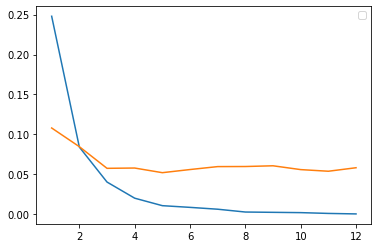

In [39]:
plt.plot(epoch_numbers, training_losses)
plt.plot(epoch_numbers, validation_losses)
plt.legend('training_loss', 'validation_loss')

In [106]:
df_test = pd.read_csv("data/test_data.csv")
df_test = pd.get_dummies(df_test, columns=['stance'])
df_test['label'] = df_test[['stance_unrelated','stance_agree','stance_disagree','stance_discuss']].values.tolist()
df_test['label'] = df_test['label'].apply(lambda x: x.index(1))

In [107]:
headlines_test = df_test['head'].values
bodies_test = df_test['body'].values
labels_test = df_test['label'].values

In [108]:
input_ids_test = []
for i in range(len(headlines_test)):
    encoded_dict = tokenizer.encode(
                        text=headlines_test[i],                      # headline to encode.
                        text_pair=bodies_test[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,
                        pad_to_max_length=True,   # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.   
    #input_ids.append(encoded_dict['input_ids'])
    input_ids_test.append(encoded_dict)
    
    # And its attention mask (simply differentiates padding from non-padding).
    #attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
#attention_masks = torch.cat(attention_masks, dim=0)
labels_test = torch.tensor(labels_test)

# Print sentence 0, now as a list of IDs.
print('Original: ', headlines_test[0], bodies_test[0])
print('Token IDs:', input_ids_test[0])

Original:  Ferguson riots: Pregnant woman loses eye after cops fire BEAN BAG round through car window A RESPECTED senior French police officer investigating the Charlie Hebdo magazine massacre took his own life mere hours after the horrific attacks stunned the world.

Commissioner Helric Fredou, 45, turned a gun on himself in his police office in Limoges last Wednesday night, reported France 3.

A colleague found his body at 1am on Thursday, the day after three gunmen fired at the satirical magazine's office and left 12 people dead.

Speaking to our sister publication Mirror Online, the Union of Commissioners of the National Police confirmed Mr Fredou had taken his own life.


In a statement released after his death, a union spokesman said: "It is with great sadness that we were informed this morning of the death of our colleague Helric Fredou, assigned as Deputy Director of the Regional Service Judicial Police in Limoges.

"On this particular day of national mourning, police commissio

In [109]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids_test, labels_test)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.

print('{:>5,} test samples'.format(len(test_dataset)))

25,413 test samples


In [110]:
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [111]:
def get_predictions_and_labels(preds, labels):
    y_pred = np.argmax(preds, axis=1).flatten().numpy()
    y_true = labels.flatten().numpy()
    return y_pred, y_true

In [112]:
print("Running test...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

# Tracking variables 
total_test_accuracy = 0
total_test_fnc_score = 0
total_test_max_fnc_score = 0
test_predictions = []
test_labels = []

# Evaluate data for one epoch
for i,batch in enumerate(test_dataloader):

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    #b_input_mask = batch[1].to(device)
    b_labels = batch[1].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        (loss, logits) = model(b_input_ids, 
                               token_type_ids=None, 
                               labels=b_labels)


    # Move logits and labels to CPU
    logits = logits.detach().cpu()
    label_ids = b_labels.to('cpu')
    
    test_preds_b, test_labels_b = get_predictions_and_labels(logits, label_ids)
    test_predictions.extend(test_preds_b.tolist())
    test_labels.extend(test_labels_b.tolist())

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_test_accuracy += flat_accuracy(logits, label_ids)

    # Calculate FNC score, max FNC score for this batch, and accumulate
    b_fnc_score, b_max_fnc_score = fnc_score(logits, label_ids)
    total_test_fnc_score += b_fnc_score
    total_test_max_fnc_score += b_max_fnc_score

# Report the final accuracy for this validation run.
avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

# Report fnc scores over validation run
relative_score_test = total_test_fnc_score / total_test_max_fnc_score
print("  FNC Score: {0:.2f}".format(total_test_fnc_score))
print("  Maximum Possible FNC Score: {0:.2f}".format(total_test_max_fnc_score))
print("  Relative FNC Score: {0:.2f}".format(relative_score_test))

# Calculate the average loss over all of the batches.
#avg_val_loss = total_eval_loss / len(validation_dataloader)

# Measure how long the validation run took.
test_time = format_time(time.time() - t0)

print("  Test took: {:}".format(test_time))

# Record all statistics from this epoch.
#return (
 #   {
  #      
 #       'Test. Accur.': avg_test_accuracy,
#        'Test Time': test_time,
  #      'Test FNC Score': total_test_fnc_score,
   #     'Valid. Max FNC Score': total_test_max_fnc_score,
   #     'Relative FNC Score': relative_score_test
   # }
#)

Running test...
  Accuracy: 0.92
  FNC Score: 10117.50
  Maximum Possible FNC Score: 11651.25
  Relative FNC Score: 0.87
  Test took: 0:01:21


In [114]:
df_test_preds_actuals = pd.DataFrame(list(zip(test_predictions, test_labels)), 
               columns =['prediction', 'actual'])

In [120]:
df_test_preds_actuals.to_csv("test_outputs.csv")